<a href="https://colab.research.google.com/github/dastias/Projeto-doutorado/blob/main/Classificadores_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import stft
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from scipy.fft import fft, ifft,rfft,irfft
from sklearn.cluster import estimate_bandwidth
import pywt

Mounted at /content/drive


### Dados Padrão

In [ ]:
dados_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_NOR.csv')
dados_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_BEA.csv')

In [ ]:
dados_mis = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_MIS.csv')
dados_unb = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_UNB.csv')

### Dados Kde

In [ ]:
normal_KDE = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/normal_filtrado_KDE_125.csv')
bea_KDE = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/bea_filtrado_KDE_125.csv')
unb_KDE = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/unb_filtrado_KDE_125.csv')
mis_KDE = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/mis_filtrado_KDE_125.csv')

### Dados Wave

In [ ]:
wave_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_normal.csv')
wave_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_bea.csv')
wave_mis = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_mis.csv')
wave_unb = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Wave_KDE/wave_unb.csv')

In [ ]:
def FFT(data):
    '''FFT process and filtering'''
    data = np.asarray(data)
    fft = abs(rfft(data))
    return fft

In [ ]:
def mean(data):
    '''Mean features'''
    data = np.asarray(data)
    M = pd.DataFrame(np.mean(data, axis=1))
    return M

In [ ]:
def pp(data):
    '''Peak-to-Peak features'''
    data = np.asarray(data)
    PP = pd.DataFrame(np.max(data, axis=1) - np.min(data, axis=1))
    return PP

In [ ]:
def rms(data):
    '''RMS features'''
    data = np.asarray(data)
    Rms = pd.DataFrame(np.sqrt(np.mean(data**2, axis=1)))
    return Rms

### Feature Dados Originais

In [ ]:
fft_normal = pd.DataFrame(FFT(dados_normal.iloc[:50]))
fft_bea = pd.DataFrame(FFT(dados_bea.iloc[:50]))
fft_mis = pd.DataFrame(FFT(dados_mis.iloc[:50]))
fft_unb = pd.DataFrame(FFT(dados_unb.iloc[:50]))

In [ ]:
data_merged = pd.concat((fft_normal, fft_bea,fft_mis,fft_unb))

In [ ]:
def NormalizeData(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged)
    data_min = np.min(data_merged)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))

In [ ]:
fft_normal_norm = NormalizeData(fft_normal)
fft_bea_norm = NormalizeData(fft_bea)
fft_mis_norm = NormalizeData(fft_mis)
fft_unb_norm = NormalizeData(fft_unb)

media_normal = mean(fft_normal_norm)
media_bea = mean(fft_bea_norm)
media_mis = mean(fft_mis_norm)
media_unb = mean(fft_unb_norm)

pp_normal = pp(fft_normal_norm)
pp_bea = pp(fft_bea_norm)
pp_mis = pp(fft_mis_norm)
pp_unb = pp(fft_unb_norm)

rms_normal = rms(fft_normal_norm)
rms_bea = rms(fft_bea_norm)
rms_mis = rms(fft_mis_norm)
rms_unb = rms(fft_unb_norm)

In [ ]:
feat_normal = pd.concat((media_normal, pp_normal, rms_normal), axis=1)
feat_bea = pd.concat((media_bea, pp_bea, rms_bea), axis=1)
feat_mis = pd.concat((media_mis, pp_mis, rms_mis), axis=1)
feat_unb = pd.concat((media_unb, pp_unb, rms_unb), axis=1)

feat_normal.columns = ['media', 'pp', 'rms']
feat_bea.columns = ['media', 'pp', 'rms']
feat_mis.columns = ['media', 'pp', 'rms']
feat_unb.columns = ['media', 'pp', 'rms']

feat_normal['cond']=0
feat_bea['cond']=1
feat_mis['cond']=2
feat_unb['cond']=3

matriz_classificacao = pd.concat((feat_normal, feat_bea, feat_mis, feat_unb))

###Classificador ANN Dados Originais


In [ ]:
X = matriz_classificacao.drop('cond', axis=1)
y = matriz_classificacao['cond']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 2s 29ms/step - loss: 1.1867 - accuracy: 0.5750 - val_loss: 1.1572 - val_accuracy: 0.6000
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 1.0657 - accuracy: 0.7063 - val_loss: 1.0463 - val_accuracy: 0.6500
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.9454 - accuracy: 0.7375 - val_loss: 0.9365 - val_accuracy: 0.6500
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.8304 - accuracy: 0.7375 - val_loss: 0.8325 - val_accuracy: 0.6500
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.7244 - accuracy: 0.7375 - val_loss: 0.7412 - val_accuracy: 0.6500
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 0.6343 - accuracy: 0.7375 - val_loss: 0.6660 - val_accuracy: 0.6500
Epoch 7/50
16/16 [==============================] - 0s 7ms/step - loss: 0.5591 - accuracy: 0.7375 - val_loss: 0.6001 - val_accuracy: 0.6500
Epoch 8/50
16/16 [

2/2 [==============================] - 0s 6ms/step
Acurácia: 0.97
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.93      0.97        15
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.98        40
weighted avg       0.98      0.97      0.98        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 14  1  0]
 [ 0  0  9  0]
 [ 0  0  0 10]]


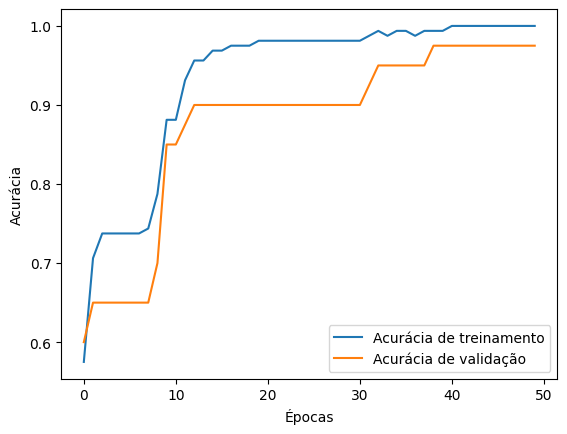

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN = model.predict(X_test)
y_pred_classes_ANN = np.argmax(y_pred_ANN, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes_ANN)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes_ANN))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### Features Dados KDE

In [ ]:
fft_normal_KDE = pd.DataFrame(FFT(normal_KDE.iloc[:50]))
fft_bea_KDE = pd.DataFrame(FFT(bea_KDE.iloc[:50]))
fft_mis_KDE = pd.DataFrame(FFT(mis_KDE.iloc[:50]))
fft_unb_KDE = pd.DataFrame(FFT(unb_KDE.iloc[:50]))

In [ ]:
data_merged_KDE = pd.concat((fft_normal_KDE, fft_bea_KDE,fft_mis_KDE,fft_unb_KDE))

In [ ]:
def NormalizeDataKDE(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged_KDE)
    data_min = np.min(data_merged_KDE)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))

In [ ]:
fft_normal_norm_KDE = NormalizeData(fft_normal_KDE)
fft_bea_norm_KDE = NormalizeData(fft_bea_KDE)
fft_mis_norm_KDE = NormalizeData(fft_mis_KDE)
fft_unb_norm_KDE = NormalizeData(fft_unb_KDE)


media_normal_KDE = mean(fft_normal_norm_KDE)
media_bea_KDE = mean(fft_bea_norm_KDE)
media_mis_KDE = mean(fft_mis_norm_KDE)
media_unb_KDE = mean(fft_unb_norm_KDE)

pp_normal_KDE = pp(fft_normal_norm_KDE)
pp_bea_KDE = pp(fft_bea_norm_KDE)
pp_mis_KDE = pp(fft_mis_norm_KDE)
pp_unb_KDE = pp(fft_unb_norm_KDE)

rms_normal_KDE = rms(fft_normal_norm_KDE)
rms_bea_KDE = rms(fft_bea_norm_KDE)
rms_mis_KDE = rms(fft_mis_norm_KDE)
rms_unb_KDE = rms(fft_unb_norm_KDE)

In [ ]:
feat_normal_KDE = pd.concat((media_normal_KDE, pp_normal_KDE, rms_normal_KDE), axis=1)
feat_bea_KDE = pd.concat((media_bea_KDE, pp_bea_KDE, rms_bea_KDE), axis=1)
feat_mis_KDE = pd.concat((media_mis_KDE, pp_mis_KDE, rms_mis_KDE), axis=1)
feat_unb_KDE = pd.concat((media_unb_KDE, pp_unb_KDE, rms_unb_KDE), axis=1)

In [ ]:
feat_normal_KDE.columns = ['media', 'pp', 'rms']
feat_bea_KDE.columns = ['media', 'pp', 'rms']
feat_mis_KDE.columns = ['media', 'pp', 'rms']
feat_unb_KDE.columns = ['media', 'pp', 'rms']

feat_normal_KDE['cond']=0
feat_bea_KDE['cond']=1
feat_mis_KDE['cond']=2
feat_unb_KDE['cond']=3

matriz_classificacao_KDE = pd.concat((feat_normal_KDE, feat_bea_KDE, feat_mis_KDE, feat_unb_KDE))

### Classificador ANN para KDE

In [ ]:
X_KDE = matriz_classificacao_KDE.drop('cond', axis=1)
y_KDE = matriz_classificacao_KDE['cond']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train_KDE, X_test_KDE, y_train_KDE, y_test_KDE = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train_KDE = scaler.fit_transform(X_train_KDE)
X_test_KDE = scaler.transform(X_test_KDE)

y_train_KDE = tf.keras.utils.to_categorical(y_train_KDE, num_classes=4)
y_test_KDE = tf.keras.utils.to_categorical(y_test_KDE, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train_KDE, y_train_KDE, epochs=50, batch_size=10, validation_data=(X_test_KDE, y_test_KDE))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test_KDE, y_test_KDE)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
16/16 [==============================] - 1s 21ms/step - loss: 1.3811 - accuracy: 0.2313 - val_loss: 1.2426 - val_accuracy: 0.4250
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 1.2375 - accuracy: 0.6187 - val_loss: 1.1453 - val_accuracy: 0.7750
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.1417 - accuracy: 0.7063 - val_loss: 1.0717 - val_accuracy: 0.8000
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 1.0798 - accuracy: 0.7250 - val_loss: 1.0081 - val_accuracy: 0.8500
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.0222 - accuracy: 0.7250 - val_loss: 0.9455 - val_accuracy: 0.8500
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.9626 - accuracy: 0.7250 - val_loss: 0.8813 - val_accuracy: 0.8500
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.8982 - accuracy: 0.7250 - val_loss: 0.8200 - val_accuracy: 0.8500
Epoch 8/50
16/16

2/2 [==============================] - 0s 6ms/step
Acurácia: 0.95
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.87      0.93        15
           2       0.90      1.00      0.95         9
           3       0.91      1.00      0.95        10

    accuracy                           0.95        40
   macro avg       0.95      0.97      0.96        40
weighted avg       0.95      0.95      0.95        40

Matriz de confusão:
[[ 6  0  0  0]
 [ 0 13  1  1]
 [ 0  0  9  0]
 [ 0  0  0 10]]


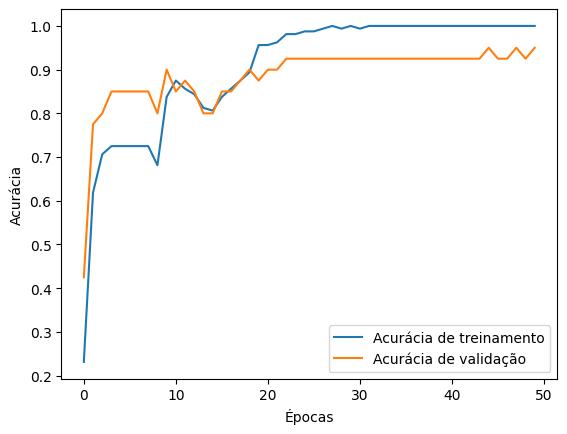

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN_KDE = model.predict(X_test_KDE)
y_pred_classes_ANN_KDE = np.argmax(y_pred_ANN_KDE, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

### SVM Originnais

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

SVM Classification Score is: 0.9


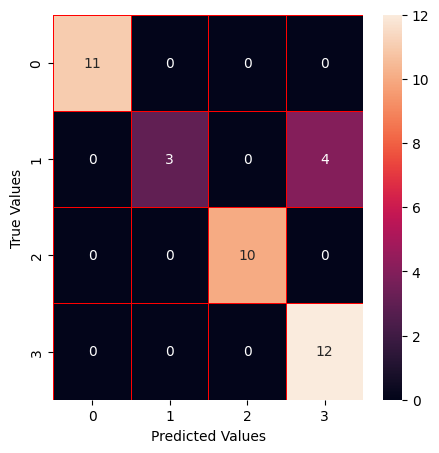

In [ ]:
import seaborn as sns
method_names = []
method_scores = []
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(x_train,y_train)
print("SVM Classification Score is: {}".format(svm.score(x_test,y_test)))
method_names.append("SVM")
method_scores.append(svm.score(x_test,y_test))

#Confusion Matrix
y_pred = svm.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

### SVM Dados KDE

SVM Classification Score is: 0.875


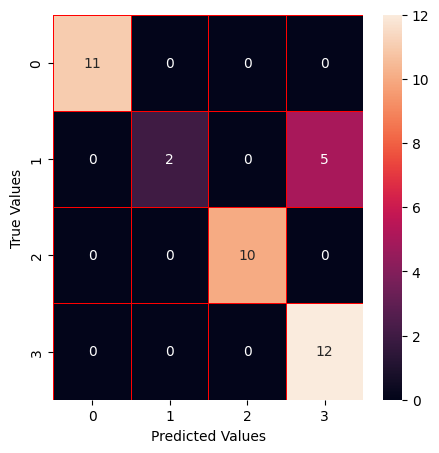

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=0)

method_names = []
method_scores = []
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(x_train,y_train)
print("SVM Classification Score is: {}".format(svm.score(x_test,y_test)))
method_names.append("SVM")
method_scores.append(svm.score(x_test,y_test))

#Confusion Matrix
y_pred = svm.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()